In [1]:
import pandas as pd 
#import yfinance as yf 
from scipy.stats import spearmanr
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 

#dict for individual stock DF storage
# stockdataframes = {}
# start_dte = "2019-01-01"
# end_dte = "2023-12-31"




In [2]:
#merge all stock dfs into one 
# full_df = pd.concat(stockdataframes.values(), keys=stockdataframes.keys())
filepath = 'Data/SP500.csv'
full_df = pd.read_csv(filepath)
#print(full_df)
print(full_df.head())

#need to cut this to just values and tickers

#full_df = full_df.reset_index(level=0) 
#print(full_df.head())
full_df['Date'] = pd.to_datetime(full_df['Date'], utc=True)
##print(full_df.head())
#df['Date'] = pd.to_datetime(df['Date'])
#full_df.set_index('Date', inplace=True)
#print(full_df['Date'].head())

last_day_of_month = full_df['Date'] + pd.offsets.MonthEnd(0)

# Use boolean indexing to filter the DataFrame for the last day of each month
last_day_df = full_df[full_df['Date'].isin(last_day_of_month)]

# Reset the index if needed
last_day_df.reset_index(drop=True, inplace=True)

print(len(last_day_df))
print(last_day_df.head())

#new_df = df.iloc[:1000].copy()
#new_df.set_index('Date', inplace=True)
# Display the new DataFrame
#print(new_df.head())

#print(full_df.info())
#print(monthly_df)
#monthly_df = full_df.resample('M').agg(list)
#monthly_df.reset_index(drop=True, inplace=True)
#print(len(monthly_df))
#print(monthly_df)
#print(len(monthly_df))
#print(len(last_day_df))
#print(last_day_df.head())
#monthly_df.show()




  Unnamed: 0                       Date       Close Symbol Security  \
0        MMM  2019-01-02 00:00:00-05:00  156.153717    MMM       3M   
1        MMM  2019-01-03 00:00:00-05:00  150.273926    MMM       3M   
2        MMM  2019-01-04 00:00:00-05:00  156.456345    MMM       3M   
3        MMM  2019-01-07 00:00:00-05:00  156.096512    MMM       3M   
4        MMM  2019-01-08 00:00:00-05:00  156.750732    MMM       3M   

   GICS Sector  
0  Industrials  
1  Industrials  
2  Industrials  
3  Industrials  
4  Industrials  
20538
  Unnamed: 0                      Date       Close Symbol Security  \
0        MMM 2019-01-31 05:00:00+00:00  163.799927    MMM       3M   
1        MMM 2019-02-28 05:00:00+00:00  170.770477    MMM       3M   
2        MMM 2019-04-30 04:00:00+00:00  156.047623    MMM       3M   
3        MMM 2019-05-31 04:00:00+00:00  132.667892    MMM       3M   
4        MMM 2019-07-31 04:00:00+00:00  145.100082    MMM       3M   

   GICS Sector  
0  Industrials  
1  Industr

In [ ]:
sp500_tickers = full_df['Symbol'].unique().tolist() 
exclude = ['BRK.B', 'BF.B', 'ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOXA', 'FOX', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO']
sp500_tickers = [ticker for ticker in sp500_tickers if ticker not in exclude]


In [ ]:
def spearman_ranking(a):
    input_array = np.array(a)
    sorted_indices = np.argsort(-input_array)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(input_array) + 1)
    return ranks


def spearman_coefficient(stock1, stock2):
    a = spearman_ranking(stock1)
    b = spearman_ranking(stock2)
    n = (len(a) + len(b)) / 2
    rho = 1 - (6 * np.sum((a - b)**2) / (n * (n**2 - 1)))
    return rho


In [ ]:
# print(len(monthly_df))
# Calculate Spearman correlation coefficient
#corr_matrix = monthly_df.pivot(columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()
# missing_values = last_day_df['Close'].isnull().sum()
# print(missing_values)
corr_matrix = last_day_df.pivot(index='Date',columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

print(corr_matrix.head())
print(len(corr_matrix))

In [ ]:
print(corr_matrix.head())

In [14]:
# Using 1 / correlation for weight
def create_base_network(corr_coef, corr_matrix, sp500_tickers):
    '''
        corr_coef: float 0 to 1
        corr_matrix: pandas df from get_corr_matrix
        sp500_tickers: python list of ticker symbols
    '''
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        G.add_node(stock) 
        
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            
            # Check if the stock symbols are present in the correlation matrix

            # CHANGED CORRELATION THRESHOLD TO THIS IF BLOCK
            if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
                correlation_coefficient = corr_matrix.loc[stock1, stock2]
                if not np.isnan(correlation_coefficient) and abs(correlation_coefficient) > corr_coef:
                    G.add_edge(stock1, stock2, weight= 1 / correlation_coefficient)
    return G

# Using 1 / correlation for weight
def create_sector_network(corr_coef, corr_matrix, sp500_tickers, sector_df, valid_sectors_array):
    '''
        corr_coef: float 0 to 1
        corr_matrix: pandas df from get_corr_matrix
        sp500_tickers: python list of ticker symbols
        sector_df: pandas df of ['Symbol'] and ['GICS Sector'] from get_sector_df
        valid_sectors_array: python list of strings of sectors to include in network
    '''
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        if stock in sector_df['Symbol'].values:
            sector = sector_df.loc[sector_df['Symbol'] == stock, 'GICS Sector'].iloc[0]
            if sector in valid_sectors_array:
                G.add_node(stock, sector = sector) 
        
    node_list = list(G.nodes())
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            # Check if the stock symbols are present in the correlation matrix
            if (stock1 not in node_list) or (stock2 not in node_list):
                continue
            # CHANGED CORRELATION THRESHOLD TO THIS IF BLOCK
            if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
                correlation_coefficient = corr_matrix.loc[stock1, stock2]
                if not np.isnan(correlation_coefficient) and abs(correlation_coefficient) > corr_coef:
                    G.add_edge(stock1, stock2, weight= 1 / correlation_coefficient)
    return G

# This function works for daily but not monthly
def dataframe_creation(time_step, start_date, end_date):
    '''
    time_step must be 'm' for months, 'd' for daily
    potentially can implement yearly
    start_date and end_date must be in 'yyyy-mm-dd' format
    '''
    # Read in all the stock data
    filepath = 'Data/SP500.csv'
    full_df = pd.read_csv(filepath)

    # Ensure all Dates are in proper format
    full_df['Date'] = pd.to_datetime(full_df['Date'], utc=True)
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = pd.to_datetime(end_date, utc=True)

    ranged_df = full_df[(full_df['Date'] >= start_date) & (full_df['Date'] <= end_date)]
    ranged_df.dropna(subset=['Date'])

    if time_step == 'm':
        return get_monthly_df(ranged_df)

    if time_step == 'd':
        return ranged_df

    return 0

# THIS FUNCTION WORKS I THINK 
def get_monthly_df(passed_df):
    # Use boolean indexing to filter the DataFrame for the last day of each month
    
    #last_day = passed_df['Date'] + pd.offsets.MonthEnd(0)
    #last_day_df = passed_df[passed_df['Date'].isin(last_day)]

    # Reset the index if needed
    #last_day_df.reset_index(drop=True, inplace=True)
    
    #passed_df.sort_values(by='Date', inplace=True)
    #try:
        #monthly_last_price = passed_df.groupby('Symbol').resample('M', on='Date')['Close'].last()
    #except Exception as e:
        #print("Error occurred during grouping and resampling:", e)
    #monthly_last_price = monthly_last_price.reset_index()
    # print(len(last_day_df))
    # print(last_day_df.head())
    '''
        Takes in the original dataframe read by the csv
        Should only be called by dataframe_creation
    '''
    unique_stocks = passed_df['Symbol'].unique()
    #last_dates = pd.DataFrame(columns=['Symbol', 'Last_Date'])
    last_dates_data = []

    for stock in unique_stocks:
        stock_df = passed_df[passed_df['Symbol'] == stock]

        stock_df.sort_values(by='Date',inplace=True)
        stock_df['Year_Month'] = stock_df['Date'].dt.to_period('M')
        max_date_per_month = stock_df.groupby('Year_Month')['Date'].max()

        for year_month, last_date in max_date_per_month.items():
            last_dates_data.append({'Symbol': stock, 'Date': last_date})


    last_dates = pd.DataFrame(last_dates_data)

    #result = pd.merge(passed_df, last_dates, on='Date', how='inner')
    result = passed_df[passed_df['Date'].isin(last_dates['Date'])]


    return result

def get_corr_matrix(df):
    '''
    Takes in the full csv dataframe and returns spearman correlation matrix 
    '''
    return df.pivot(index='Date',columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

# Sectors are :
#   Industrials, Health Care, Information Technology, Utilities, Financials, Materials
#   , Real Estate, Communication Services, Consumer Staples, Consumer Discretionary
#   , Energy
def get_sector_df(df):
    '''
        Takes in the full dataframe read from csv and returns
        a dataframe consisting of symbols(unique) and sectors
    '''
    return_df = df[['Symbol', 'GICS Sector']]
    return_df = return_df.drop_duplicates(subset=['Symbol'])
    return_df = return_df.reset_index(drop=True)
    return return_df






plot_log_deg_dis() and plot_lin_deg_dist() were sourced from Emma Towlson.

Towlson, E (2024) networkx-W3L5.ipynb Juptyer Notebook 

In [16]:
# THIS CODE NEEDS TO BE CITED TO EMMA TOWLSON
def plot_log_deg_dist(G, title):
    '''
        Takes in a graph as paramter
        title should be worded to fit with: 'Log-Log Degree Distribution of...'
        Will plot the log scale degree distribution
        IMPORTANT:
            If a graph has nodes with degree 0, this function will be inaccurate
            This function removes nodes with degree 0
        
    '''

    degrees = [G.degree(node) for node in G if G.degree(node) > 0]
    kmin = min(degrees)
    kmax = max(degrees)

    # Get 10 logarithmically spaced bins between kmin and kmax
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

    # histogram the data into these bins
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    fig = plt.figure(figsize=(6,4))

    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(f'Log-Log Degree Distribution of {title}')

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
  

    # Show the plot
    plt.show()

# THIS CODE NEEDS TO BE CITED TO EMMA TOWLSON
def plot_lin_deg_dist(G, title):

    '''
        Takes in a graph as paramter
        title should be worded to fit with: 'Linear Degree Distribution of...'
        Will plot the log scale degree distribution
        IMPORTANT:
            If a graph has nodes with degree 0, this function will be inaccurate
            This function removes nodes with degree 0
        
    '''
    degrees = [G.degree(node) for node in G if G.degree(node) > 0]
    kmin = min(degrees)
    kmax = max(degrees)
    # Get 20 logarithmically spaced bins between kmin and kmax
    bin_edges = np.linspace(kmin, kmax, num=10)

    # histogram the data into these bins
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    fig = plt.figure(figsize=(6,4))

    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.plot(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(f'Linear Degree Distribution of {title}')
    

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Show the plot
    plt.show()


In [6]:
#Testing functions out
testing_df = dataframe_creation('d', '2019-01-01', '2019-01-30')
#print("Length of the df is: ", len(testing_df))
#print(testing_df.head())
testing_corr = get_corr_matrix(testing_df)
#print(testing_corr.head())
sector_df = get_sector_df(testing_df)
#print("Length of the df is:", len(sector_df))
#print(sector_df.head())
#basic_graph = create_base_network(0.7, testing_corr, sp500_tickers,)
#print("Basic Nodes: ", basic_graph.number_of_nodes())
#print("Basic Edges: ", basic_graph.number_of_edges())
oil_graph = create_sector_network(0.7, testing_corr, sp500_tickers, sector_df, ['Energy', 'Real Estate']) 
print("Sector Nodes: ", oil_graph.number_of_nodes())
print("Sector Edges: ", oil_graph.number_of_edges())

Sector Nodes:  54
Sector Edges:  166


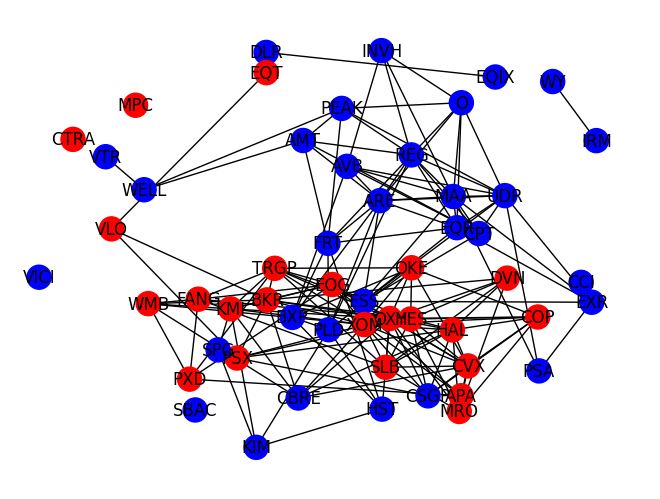

In [7]:
sector_colors = {
    'Energy':'red',
    'Real Estate': 'blue',
}
pos = nx.spring_layout(oil_graph, k=1)
node_colors = [sector_colors[oil_graph.nodes[node]['sector']] for node in oil_graph.nodes()]
nx.draw(oil_graph,pos, labels={node: node for node in oil_graph.nodes()}, node_color=node_colors)

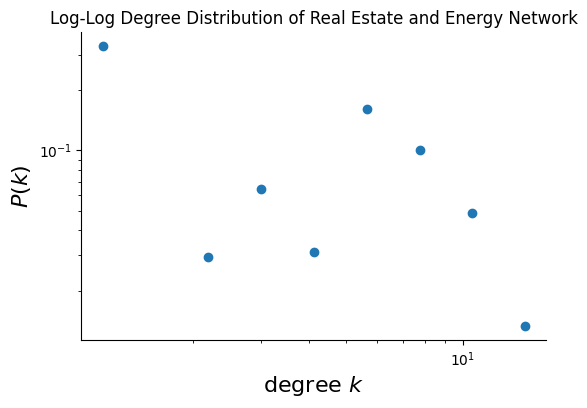

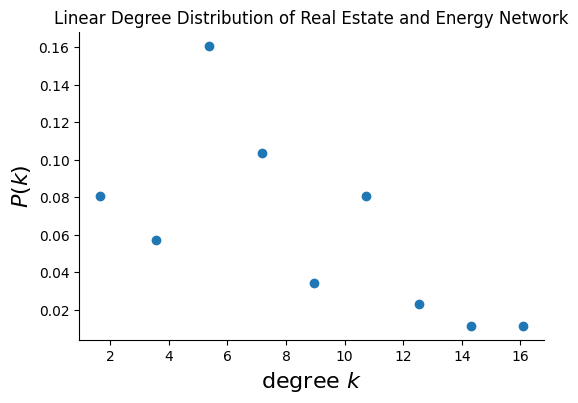

In [17]:
plot_log_deg_dist(oil_graph, 'Real Estate and Energy Network')
plot_lin_deg_dist(oil_graph, 'Real Estate and Energy Network')

In [ ]:
months = dataframe_creation('m', '2019-01-01', '2020-01-30')
print(len(months))
print(months.head())

In [18]:
# TESTING MONTHLY

#Testing functions out
mt = dataframe_creation('m', '2019-01-01', '2023-08-30')
#print("Length of the df is: ", len(testing_df))
#print(testing_df.head())
m_corr = get_corr_matrix(mt)
#print(testing_corr.head())
m_sec = get_sector_df(mt)
#print("Length of the df is:", len(sector_df))
#print(sector_df.head())
#basic_graph = create_base_network(0.7, testing_corr, sp500_tickers,)
#print("Basic Nodes: ", basic_graph.number_of_nodes())
#print("Basic Edges: ", basic_graph.number_of_edges())
m_graph = create_sector_network(0.7, m_corr, sp500_tickers, m_sec, ['Energy', 'Real Estate']) 
print("Sector Nodes: ", oil_graph.number_of_nodes())
print("Sector Edges: ", oil_graph.number_of_edges())

/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_4946/2834442248.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.sort_values(by='Date',inplace=True)
/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_4946/2834442248.py:121: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_df['Year_Month'] = stock_df['Date'].dt.to_period('M')
/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_4946/2834442248.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Year_Month'] = stoc

Sector Nodes:  54
Sector Edges:  166


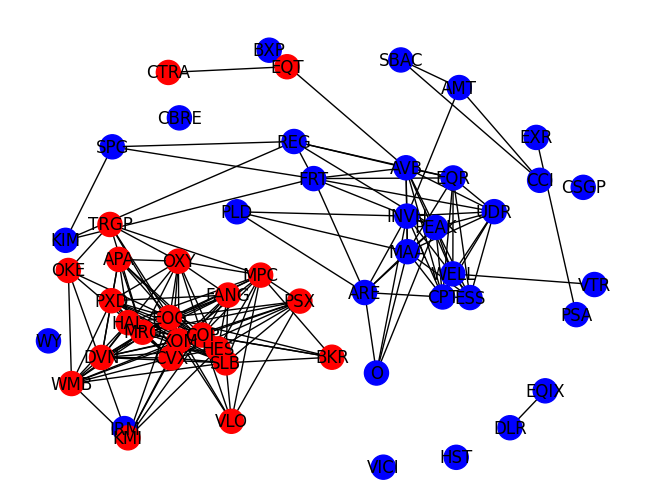

In [19]:

mpos = nx.spring_layout(m_graph, k=1)
m_node_colors = [sector_colors[m_graph.nodes[node]['sector']] for node in m_graph.nodes()]
nx.draw(m_graph,mpos, labels={node: node for node in m_graph.nodes()}, node_color=m_node_colors)

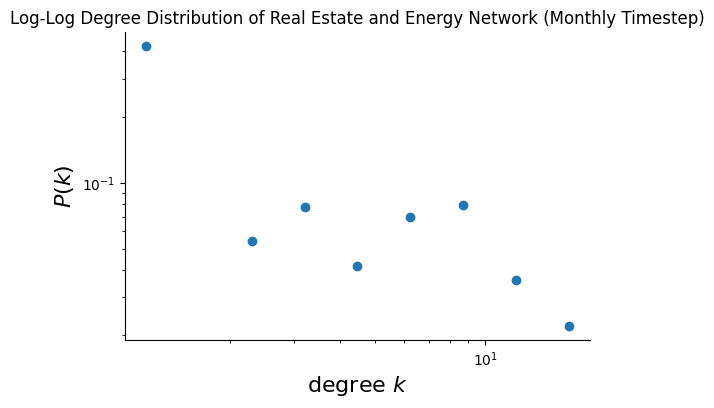

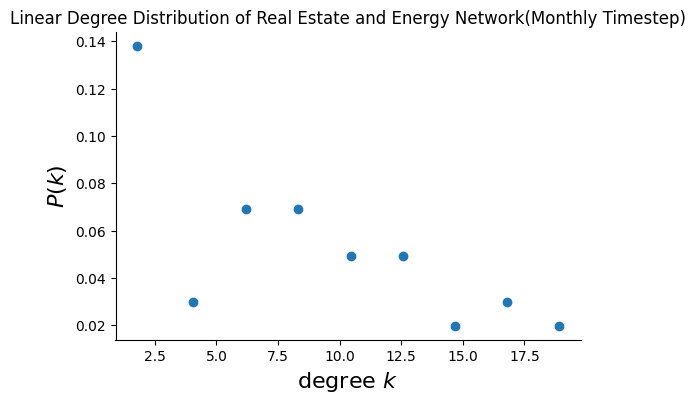

In [20]:
plot_log_deg_dist(m_graph, 'Real Estate and Energy Network (Monthly Timestep)')
plot_lin_deg_dist(m_graph, 'Real Estate and Energy Network(Monthly Timestep)')

# FRICK YEAH MONTHLY IS UP AND RUNNING MY FELLOW GROUP MEMBER!!


In [ ]:

#create graph 
G = nx.Graph() 

for stock in sp500_tickers: 
    G.add_node(stock) 
    
#add links 
for i in range(len(sp500_tickers)): 
    for j in range(i + 1, len(sp500_tickers)):
        stock1 = sp500_tickers[i]
        stock2 = sp500_tickers[j]
        
        # Check if the stock symbols are present in the correlation matrix

        # CHANGED CORRELATION THRESHOLD TO THIS IF BLOCK
        if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
            correlation_coefficient = corr_matrix.loc[stock1, stock2]
            if not np.isnan(correlation_coefficient) and abs(correlation_coefficient) > 0.7:
                G.add_edge(stock1, stock2, weight=correlation_coefficient)




In [ ]:
print("At visualization")
#visualization 
#pos = nx.spring_layout(G, seed=42)
pos = nx.spring_layout(G)
# Draw only edges with significant correlation

# I COMMENTED OUT THIS LINE BECAUSE I THINK IT DOES NOTHING
# I MOVOED THE CORRELATION THRESHOLD TO THE PREVIOUS CELL
#edges = [(source, target) for source, target, data in G.edges(data=True) if abs(data['weight']) > 0.5]


# NEED TO FLIP THE WEIGHTS OF THE SPEARMAN
nx.draw_networkx_nodes(G, pos, node_size=30)
#nx.draw_networkx_labels(G, pos, font_size=8)
print("Drawing edges")
#nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')
print("Done Drawing edges")
labels = nx.get_edge_attributes(G, 'weight')
print("drawing edge labels")
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
print("End")
#nx.draw_circular(G, node_size=40)
#nx.draw_kamada_kawai(G, node_size=40)
#nx.draw_spectral(G, node_size=40)
# deg = G.degree()
# to_remove = [n for n in deg if deg[n] == 0]
# G.remove_nodes_from(to_remove)
# nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
# print(nodes_to_remove)
# G.remove_nodes_from(nodes_to_remove)
#G.remove_nodes_from((n for n,d in G.degree_iter() if d == 0))
nx.draw_circular(G, node_size=40)
#plt.show() #its a bullshit hgraph and idk if the coefficient is actually doing anything  useful here


In [ ]:
print(G.size()) # edges
print(len(G)) # nodes
degrees = [G.degree(node) for node in G]
print("Average Degree:", np.mean(degrees))

The following code was sourced from Emma Towlson.

Towlson, E (2024) networkx-W3L5.ipynb Juptyer Notebook 

In [ ]:
degrees = [G.degree(node) for node in G]
print("OG", len(degrees))
degrees = [degree for degree in degrees if degree > 0]
print("MOD", len(degrees))
kmin = min(degrees)
kmax = max(degrees)
print(kmin)
print(kmax)
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

In [ ]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
#plt.title(r"Degree Distribution With 0.7 Correlation Threshold")

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [ ]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
#plt.title(r"Degree Distribution 0.7 Correlation Threshold")

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [ ]:
#nx.write_gml(G, '500trialpoint7.gml')

# Null Model

The following code was adapted from code provided by Emma Towlson.

Towlson, E (2024) Real World Networks - Null Models Exercise.ipynb Jupyter Notebook

In [ ]:
import matplotlib as mpl
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [ ]:
# Function Defintions

# Function to plot a degree distribution graph (P(k) vs k graph)
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [ ]:
degrees = [G.degree(node) for node in G]
degrees = [degree for degree in degrees if degree > 0]
D = G.copy()
for node in D:
    if G.degree(node) < 1:
            G.remove_node(node)

G_c = np.mean(list(nx.clustering(G).values()))
#G_d = nx.average_shortest_path_length(G)

print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())
print("Average Clustering Coefficient:", G_c)
#print("Average Shortest Path:", G_d)
#plot_degree_dist(D)

In [ ]:
GN = len(G.nodes()) # G.number_of_nodes()
max_L = GN*(GN-1)/2
actual_L = len(G.edges())
p = actual_L/max_L

ER = nx.erdos_renyi_graph(GN, p, directed=False)
clustering_ER = []
short_path_ER = []

for i in range(100): # 1000 is better
    
    ER = nx.erdos_renyi_graph(GN, p, directed=False)
    C_ER = np.mean(list(nx.clustering(ER).values()))
    if nx.is_connected(ER)==True:
        d_ER = nx.average_shortest_path_length(ER,weight=None)
    clustering_ER.append(C_ER)
    short_path_ER.append(d_ER)
    
print("1000 Erdos Renyi networks of same size as network")
print("\tAverage Clustering Coefficient:", np.mean(clustering_ER))
print("\tStandard Deviation of Clustering Coefficient:", np.std(clustering_ER))
print("\tAverage Shortest Path:", np.mean(short_path_ER))
print("\tStandard Deviation of Shortest Path:", np.std(short_path_ER))

In [ ]:
DP = G.copy() # the function edits the graph in place

nx.double_edge_swap(DP,nswap=1*G.number_of_edges(),max_tries=1000000)
clustering_DP = []
short_path_DP = []
# ONLY RUNNING 10 TIMES BECAUSE EVEN 100 TIMES WILL TAKE AROUND 20 MINTUES TO COMPUTE
for i in range(10): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=1*G.number_of_edges(),max_tries=1000000)
    C_DP = np.mean(list(nx.clustering(DP).values()))
    if nx.is_connected(DP)==True:
        d_DP = nx.average_shortest_path_length(DP,weight=None)
    clustering_DP.append(C_DP)
    short_path_DP.append(d_DP)
    

print("100 Degree Preservation networks of same size as Dolphin network")
print("\tAverage Clustering Coefficient:", np.mean(clustering_DP))
print("\tStandard Deviation of Clustering Coefficient:",np.std(clustering_DP))

print("\tAverage Shortest Path:", np.mean(short_path_DP))
print("\tStandard Deviation of Shortest Path:", np.std(short_path_DP))

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot([clustering_ER,clustering_DP], positions=[1,2])
plt.plot(3,G_c,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2,3],labels=['ER','DP','S&P 500'])
plt.ylabel('Clustering')
plt.xlim([0.5,3.5])
plt.show()

# fig = plt.figure(figsize=(6,4))

# plt.boxplot([short_path_ER,short_path_DP], positions=[1,2])
# plt.plot(3,G_d,'r',marker='+',markersize=15)
# ax = plt.gca()
# ax.set_xticks([1,2,3],labels=['ER','DP','S&P 500'])
# plt.ylabel('Average shortest path')
# plt.xlim([0.5,3.5])
# plt.show()